# MATH80629A
# Week \#3 - Supervised Learning - Exercices

In this practical session we will explore several classification  models.

In [1]:
import pandas as pd
import numpy as np   
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
from sklearn.datasets import make_classification

# Code to obtain utils.py
!rm -rf 80-629
!git clone https://github.com/lcharlin/80-629/
import sys
sys.path += ['80-629/week3-Supervised/']


from utils import generate_data, plot_predictions, plot_svc_decision_function

Cloning into '80-629'...
remote: Enumerating objects: 797, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 797 (delta 12), reused 20 (delta 11), pack-reused 774
Receiving objects: 100% (797/797), 101.99 MiB | 2.58 MiB/s, done.
Resolving deltas: 100% (462/462), done.


### First let's generate three datasets and plot the training and testing splits

We will use 3 distinct binary classification datasets. Each datum is in two dimensions. 

Each dataset contains a training set and a test set. Each of the datasets was generated by a distinct data generative process, resulting in distinct class separations.

We start by visualizing the three datsets.

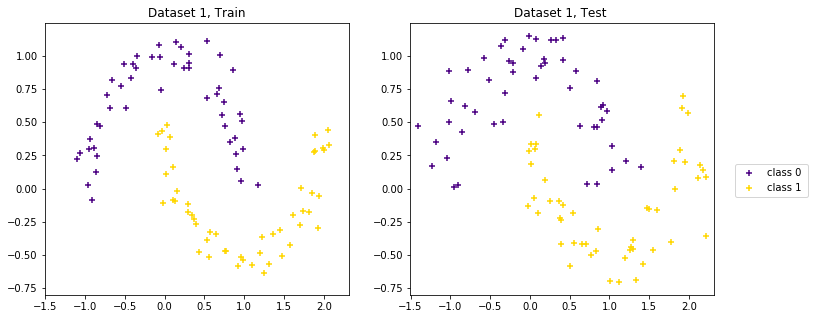

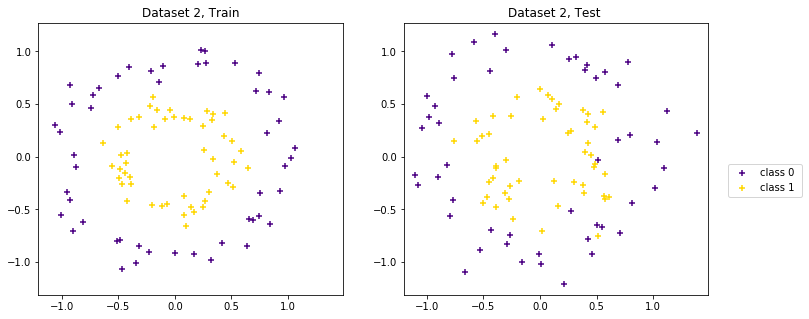

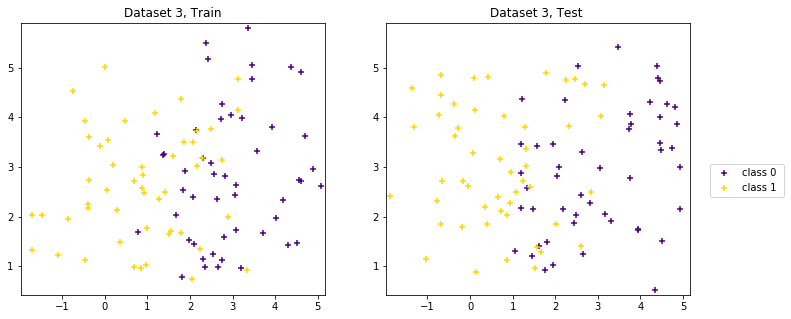

In [2]:
datasets_train, datasets_test = generate_data()

for i, (ds_train, ds_test) in enumerate(zip(datasets_train, datasets_test)):
    ds_train = datasets_train[i]
    ds_test = datasets_test[i]

    X = ds_train[0]
    Y = ds_train[1]
    
    X_test = ds_test[0]
    Y_test = ds_test[1]

    i_c0 = (Y == 0)
    i_c1 = (Y == 1)
    
    #TRAIN: true and false predictions 
    i_c0_t = (Y[i_c0]==0); i_c0_f = (Y[i_c0]==1)
    i_c1_t = (Y[i_c1]==1); i_c1_f = (Y[i_c1]==0)
    
    plot_predictions(i+1, X, Y, X_test, Y_test, pred_train=Y, pred_test=Y_test )

## 1. Linear Classification

### 1.1. Linear least squares for classification

In the previous practical session, we explored how to tune a linear regression using a least squares loss function. We saw that minimization of the least square loss function led to a simple closed-form solution (see also Week #2 Slide 31). 

As discussed in the capsules, a similar idea can also be usef for classification tasks, with the difference that now we additionally require a decision rule for classification. The decision rule will allow us to classify the predicted values (*real numbers*) in a class (for example *binary*). 

We express the decision rule as $sign(y(x))$, where $y(x) = W^\top x$ is our model. 

Where we define: 

$$ sign(a) = \left\{\begin{array}{} 
+1, &\text{if } a > 0\\
-1, &\text{otherwise}
\end{array}\right. $$

Thus, such a classifier will return class '+1' for all the points lying on one side of the decision boundary and '-1' for the ones lying on the other side.

Let's implement this simple classifier.

In [4]:
# least squares for classification
def train_LSC(X, Y):
    #Note: we transform the labels from {0,1} to {-1,+1}
    Y = (ds_train[1]*2)-1
    Y = Y.reshape(Y.size,1)
    
    # We learn the parameters of the model 
    # (this is the same estimation as the one last week for OLS)
    A = np.linalg.inv(np.dot(X.T, X))
    B = np.dot(X.T, Y)
    
    return np.dot(A, B)

# for visualizing the decision boundary 
def calculate_decision_boundary(W):
    x_1 = np.linspace(-10,10) # <- this would give x1;
    
    #the goal is to calculate x2 given x1 and the weights    
    x_2 = (-W[0] - W[1]*x_1) / W[2] 
    return x_1, x_2

In [ ]:
for i, (ds_train, ds_test) in enumerate(zip(datasets_train, datasets_test)):
    ds_train = datasets_train[i]
    ds_test = datasets_test[i]

    X = ds_train[0]
    #Add a column of ones to account for the bias term
    X_b = np.array([np.ones(len(X)), X[:,0], X[:,1]]).T
    ####
    Y = ds_train[1]
    X_test = ds_test[0]

    #Add a column of ones to account for the bias term
    X_test_b = np.array([np.ones(len(X_test)), X_test[:,0], X_test[:,1]]).T
    ###

    Y_test = ds_test[1]

    # 1) train weights
    #let k be the number of casses (2), dim - dimentionality of the data (2)
    W = train_LSC(X_b, Y) # dim x k

    # 2) Calculate the discriminant function and predict 
    # a) for test data
    y_x = np.dot(W.T, X_test_b.T)
    pred_test = 1*(y_x>0)[0]

    # b) for training data
    y_x = np.dot(W.T, X_b.T)
    pred_train = 1*(y_x>0)[0]

    
    # 3) Calculate decision boundary
    line_x, line_y = calculate_decision_boundary(W)
    
    
    # 4) plot predictions
    plot_predictions(i+1 ,X,Y, X_test, Y_test, pred_train, pred_test, line_x, line_y)

**Question 1 (Lin. Classifier):** for which dataset does the model achieve the best performance? Explain in your own words, why this is the case.

### 1.2. SVM

Here we will use the sklearn library for the first time. We will train and evaluate a Suport Vector Machine (SVM) model, which was brefly introduced in the capsules.

First, let's generate some linearly separable data.

In [ ]:
#let's load a new linearly separable dataset
X_l,Y_l = make_classification(n_features=2, n_redundant=0, n_informative=2,
                               random_state=1, n_clusters_per_class=1)
fig = plt.figure(figsize = (10,5))
xfit = np.linspace(-2, 2)
plt.scatter(X_l[:, 0], X_l[:, 1], c=Y_l)

for m, b, d in [(1.5, 1, 0.2), (10, 1, 2), (-1.5, 1.2, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)
plt.xlim(-2,2)
plt.ylim(-0.5,2.2)

We see that there exist many decision boundaries can be used to separate the given dataset.

SVM choses the line that maximizes the margin to the closest point. Let's use sklearn to train an SVM model and visualize the results.

In [ ]:
#import the SVM classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear', C=1E10)

#let us fit the model (learn its parameters)
model.fit(X_l, Y_l)

In [ ]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax.scatter(X_l[:, 0], X_l[:, 1], c = Y_l)
ax = plot_svc_decision_function(model,ax)

We see that the model has chosen the decision boundary with the maximal margin. Here, the pivot elements that touch the (dotted) margins are called support vectors.

Let's now try to classify Dataset 3 from our innitial set using SVM.

In [ ]:
X, Y = datasets_train[2]
X_test, Y_test = datasets_test[2]

# DEFINE SVM model
model = SVC(kernel='linear', C=1E10)

#let's fit the model (learn its parameters)
model.fit(X, Y)


fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)

plt.scatter(X[:, 0], X[:, 1], c=Y)
plot_svc_decision_function(model,ax)

**Question 1 (SVM)**: complete the cell below to calculate the training and the test accuracy of the above model.

Hint: check the documentation of the sklearn SVM classifier [here](https://scikit-learn.org/stable/modules/svm.html#svc). Find the function that would return the predictions for the trained model.

In [ ]:
acc_train = None #QUESTION - complete this line
acc_test =  None #QUESTION - complete this line

print("Accuracy train: ", acc_train, "%")
print("Accuracy test: ",  acc_test, "%")

We can see that our dataset is noisy, i.e. the data points from the two classes overlap and there is no decision boundary for our SVM model that can perfectly separate all the points.

While a large amount of research has been conducted on SVMs providing a solid theoretical foundation for this algorithm, here we will solely try to gain some intuition on how the algorithm works. Intuitively, the algorithm tries to optimize the trade-off between maximizing the margin around the decision boundary and minimizing the training error. We see in the above graph that the margin around the decision boundary is so tiny that it is almost not visible (no dotted lines). One of the possible reasons for this is that the trade-off between the error minimization and maximization of the margin around the decision boundary is miscalibrated. 

As mentioned in the previous tutorial, hyperparameter tuning is very important in machine learning and (almost) any result can be improved through hyperparameter tuning.

**Question 2 (SVM): [Advanced question that goes beyond the material covered in the capsule]** check the documentation of the sklearn SVM classifier [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Try to find the parameter that controls the regularization strength and change it in the definition of the SVM model above to allow for a "softer-margin". Measure the performance of your model. Can you observe any improvement?


Now, let's run the SVM classifier on all the 3 datasets (*Note: please complete the previous question first, otherwise this next cell will run for a long time*).

In [ ]:
for i, (ds_train, ds_test) in enumerate(zip(datasets_train, datasets_test)):
    ds_train = datasets_train[i]
    ds_test = datasets_test[i]

    X = ds_train[0]
    Y = ds_train[1]
    
        
    X_test = ds_test[0]
    Y_test = ds_test[1]
    # 1) train weights
    #let's fit the model (learn its parameters)
    #we use the model form the cell above
    model.fit(X, Y)

    # 2) Calculate the discriminant function and predict 
    # a) for test data
    pred_test = model.predict(X_test)

    # b) for training data
    y_x = np.dot(W.T, X_b.T)
    pred_train = model.predict(X)

    
    # 4) plot predictions
    plot_predictions(i,X,Y, X_test, Y_test, pred_train, pred_test, plot_svm=model)

## 2. Probabilistic Models

### 2.1. Naive Bayes 

Up to now we used linear classifiers, that is classifiers with a linear decision boundary. Here, we will implement the Naive Bayes classifier. It was introduced in the capsules and we will see if this classifier can come up with better decision boundaries.

In our toy datasets, the target variables $y \in \{0,1 \}$ are simple binary variables, and hence, can be modelled with a *Bernoulli* distribution $p(y=k|\pi) = \pi^k(1-\pi)^{1-k}$. Our feature variables $x \in \mathbb{R}^2$ are continuous variables. As discussed in the class, we can model continuous variables with a Gaussian distribution $\mathcal{N}(x_j | \mu_{jk}, \sigma^2_{jk})$.


The fitting procedure for a Naive Bayes classifier is described below. Fill in the gaps with missing text (double-click on this cell to be able to edit in the text).
    
   1. Calculate maximum likelihood estimate (MLE) for all the parameters of our distributions: 
     $\theta \in \{$<font size="2" color='red'> $  \sigma^2_{jk}, \mu_{jk}, \pi   $ </font> \} using the training set.
   2. Use the estimated parameters and the <font size="2" color='red'> Bayes  </font> theorem to make predictions. The corresponding formula is
   
   $posterior  \propto joint \space distribution = class\space conditional * class\space prior$
   
   $P(y = k|x) \propto$  <font size="2" color='red'> P(y = k, x) = P(x | y = k) P(y)  </font>.

Let's start by building the Naive Bayes model for our second dataset. After, we can easily train and test our implementation on all datasets.

In [ ]:
X, Y = datasets_train[1]          # we use the 2 circles dataset
X_test, Y_test = datasets_test[1] # we use the 2 circles dataset

#class indices
i_c0 = (Y == 0)
i_c1 = (Y == 1)

X_0 = X[i_c0] #data of class 0
X_1 = X[i_c1] #data of class 1

#### Training the model

Let's start by calculating the prior probability for each class. The MLE (maximum likelihood estimate) of a Bernoulli random variable  is simply given by the sample mean:
\begin{align}
    \hat{\pi} = \frac{\sum_{i=0}^n y_i}{n}, 
\end{align}
where $n$ is the total number of samples.

**Question 2 (NB):** Fill in missing code in the following cell to calculate the prior probabilities for each class.

In [ ]:
def calculate_prios(X_0, X_1, X):
    # TODO: calculate prior class 1
    prior_k0 = 0 # TODO: fix this line

    # TODO: calculate prior class 0
    prior_k1 = 0 # TODO: fix this line

    #let's store the priors in a dictionary
    prior_dict = {"class 0":prior_k0 , "class 1":prior_k1  }
    
    return prior_dict

In [ ]:
prior_dict = calculate_prios(X_0, X_1, X)
print(prior_dict)

Let's calculate the MLE for the parameters of a Gaussian. Note that although the Gaussian is embedded into a larger NB model, taking the log of the likelihood separates the different terms. We can call each dimension of our input dataset X a *feature*.

As explained e.g. [here](https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood), the maximum likelihood estimates of the **mean** is simply the empirical mean:

$\hat{\mu} = \frac{1}{n} \sum_{i=0}^{n} x^{(i)}$. For our algorithm we need to calculate this quantity for each class ($k$) and for each feature ($j$):
\begin{align}
    \hat{\mu}_{jk} = \frac{\sum_{i=0}^{n} \mathbb{1}(y^{(i)}=k) x_{j}^{(i)}}{ \sum_{i=0}^{n} \mathbb{1}(y^{(i)}=k)} 
\end{align}
(*Note, $\mathbb{1}(y^{(i)}=k)$ evaluates to 1 when $y^{(i)}=k$ and to 0 otherwise.*)


Further, the MLE of the *variance* of a Gaussian distribution is simply the empirical variance: 

$\hat{\sigma}^2 = \frac{1}{n} \sum_{j=0}^{n} (x^{(j)} - \mu)^2$

(*Note the variance also needs to be calculated per class per feature using our training data.*)


**Question 3 (NB)**: complete the implementation of the MLE estimates in the cell below.

In [ ]:
def calculate_MLE(X_0,X_1):
    #Calculate statistics for features per class
    class_summaries = dict()

    feat_0_class_0 = np.mean(X_0[:,0]), np.std(X_0[:,0])
    feat_1_class_0 = np.mean(X_0[:,1]), np.std(X_0[:,1])

    #put them in the summaries dictionary
    class_summaries['class 0'] = [feat_0_class_0, feat_1_class_0]

    feat_0_class_1 = 0,0 #QUESTION <- complete this line by calculating the statistics for class 1 feature 0
    feat_1_class_1 = 0,0 #QUESTION <- complete this line by calculating the statistics for class 1 feature 1
    
    #put them in the summaries dictionary
    class_summaries['class 1'] = [feat_0_class_1, feat_1_class_1]
    return class_summaries

In [ ]:
class_summaries = calculate_MLE(X_0, X_1)
#lets print the result
for c, class_summary in class_summaries.items():
    print(c)
    print(class_summary)

To summarize:

- Our *class_summaries* dictionary (printed in the previous cell) contains a list with empirical mean and variance of each features for each of the two classes calculated on our training data .

- Our *prior_dict* dictionary contains the prior probabilities for each class.

Congratulations, we have completed the training procedure of our Naive Bayes classifier. 


#### Now let's make predictions using our trained model.

Since we assumed that our features are drawn from Gaussian distributions, we need to implement the Gaussian probability density function (pdf) that will return the probability of the input for a given mean and variance parameters (we will use the per class MLE parameters estimated earlier).

$ \mathcal{N}(x,\mu,\sigma) = \frac{1}{ \sigma \sqrt{2 \pi}} e^{\left(-\frac{{\left(\mu - x\right)}^{2}}{2 \, \sigma^{2}}\right)} $


In [ ]:
def Gaussian_PDF(x, mean, stdev):
    exponent = np.exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (np.sqrt(2 * np.pi) * stdev)) * exponent


Now, let's apply our model to a single test point. 

Remember, all we need to do is to apply the Bayes theorem using the parameters we estimated earlier.

In [ ]:
#test point
test_point = X_test[2]
print('test point: ', test_point)
print(f'value of feature 1: {test_point[0]}, value of feature 2: {test_point[1]}')

**Question 4 (NB):** complete the function in the cell below that calculates the posterior probability for a given test point.

In [ ]:
def calculate_probability(x_test, class_summaries, prior_dict):
    # we will store our resulting probabilities in this dictionary:
    resulting_probabilities = dict() 
    
    
    for c, class_stats in class_summaries.items():

        prior_c= prior_dict[c]
        resulting_probabilities[c] = prior_c # put P(y) in the dictionary containing the result

        for i, feature_stat in enumerate(class_stats):
            mean, stdev = feature_stat
            resulting_probabilities[c] *= 0 #QUESTION <- complete this line, here the posterior for the test sample should be calculated
    
    return resulting_probabilities
        
    

In [ ]:
probs = calculate_probability(test_point, class_summaries,prior_dict)
print(probs)

The output *'probs'* is a dictionary containing quantities proportional to the posterior porobability of each class given the input data sample. Our decision rule will be simply to pick the class with the highest unnormalized probability.

**Question 5 (NB)**: describe why the Naive Bayes classifier is called 'naive'? State the line from the *'calculate_probability'* function that implements the 'naive' assumption.

**(Bonus) Question 6 (NB)**: why the output probabilities of our Naive Bayes classifier don't sum to 1?

Hint: have a look on the formula we used for the posterior calculation defined at the beginning of the section.

Let's run our Naive Bayes mode on all the 3 datasets:

In [ ]:
def train_NB(X,Y):
    #class indices
    i_c0 = (Y == 0)
    i_c1 = (Y == 1)

    X_0 = X[i_c0] #data of class 0
    X_1 = X[i_c1] #data of class 1
    
    prior_dict = calculate_prios(X_0, X_1, Y)
    
    #Calculate statistics for features per class
    class_summaries = calculate_MLE(X_0,X_1)
    
    return prior_dict, class_summaries


def test_NB(X, class_summaries, prior_dict):
    result = []
    for x_test in X:
        probs = calculate_probability(x_test, class_summaries, prior_dict)
        result.append(list(probs.values()))
    return np.array(result)
    
    

In [ ]:
for i, (ds_train, ds_test) in enumerate(zip(datasets_train, datasets_test)):
    ds_train = datasets_train[i]
    ds_test = datasets_test[i]

    X = ds_train[0]
    Y = ds_train[1]
    
        
    X_test = ds_test[0]
    Y_test = ds_test[1]
    # 1) train model
    prior_dict, class_summaries = train_NB(X,Y)
    
    # 2) Predict 
    # a) for test data
    posterior = test_NB(X_test,class_summaries, prior_dict )
    pred_test = np.argmax(posterior,1)

    # b) for training data
    posterior = test_NB(X, class_summaries, prior_dict )
    pred_train = np.argmax(posterior,1)

    
    #4) plot predictions
    plot_predictions(i,X,Y, X_test, Y_test, pred_train, pred_test)

**Question 7 (NB):** for which datasets did the Naive Bayes classifier perform well? Describe in your own words why this is the case. Why did the Naive Bayes classifier work so badly for the first dataset?

Of course sklearn package offers an implementation of the Naive Bayes classifier. Let's try it out.

In [ ]:
from sklearn.naive_bayes import GaussianNB

for i, (ds_train, ds_test) in enumerate(zip(datasets_train, datasets_test)):
    ds_train = datasets_train[i]
    ds_test = datasets_test[i]

    X = ds_train[0]
    Y = ds_train[1]
    
        
    X_test = ds_test[0]
    Y_test = ds_test[1]
    # 1) train weights
    model = GaussianNB()
    #let's fit the model (learn its parameters)
    model.fit(X, Y)

    # 2) Calculate the discriminant function and predict 
    # a) for test data
    pred_test = model.predict(X_test)

    # b) for training data
    y_x = np.dot(W.T, X_b.T)
    pred_train = model.predict(X)

    
    # 4) plot predictions
    plot_predictions(i,X,Y, X_test, Y_test, pred_train, pred_test,  plot_nb=model )

### 2.2. Example of Naive Bayes for text classification.

Now that we have understood how Naive Bayes works, let's walk through a text classification example taken from the  exercises notebook accompanying the 'Python Data Science Handbook' [book](https://www.oreilly.com/library/view/python-data-science/9781491912126/).

Let's now apply the Naive Bayes classifier to the text classification task. As discussed in class, in text classification the features are related to word counts or frequencies within the documents to be classified.

Let's download the 20 Newsgroups corpus and take a look at some target names.

In [ ]:
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()
data.target_names

For simplicity here, we will select just a few of these categories, and download the training and testing set:

In [ ]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Here is an example exntry from the data:

In [ ]:
print(train.data[5])

Let's convert the content of each string into a vector of numbers using the [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) vectorizer and create a pipeline that attaches it to a multinomial Naive Bayes classifier.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

We can now fit the model on the training data and predict the labels for the unseen test data.

In [ ]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Let's evaluate the performance of our learned classifier using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix):

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we can see, this simple classifier is able to relatively well separate the space talk from the computer talk, but it gets confused between talks about religion and Christianity.

The very cool thing here is that we now have the tools to determine the category for *any* string, using the ``predict()`` method of this pipeline.
Here's a quick utility function that will return the prediction for a single string:

In [ ]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [ ]:
predict_category('sending a payload to the ISS')

In [ ]:
predict_category('discussing islam vs atheism')

In [ ]:
predict_category('determining the screen resolution')

Remember that this is nothing more sophisticated than a simple probability model for the (weighted) frequency of each word in the string; nevertheless, the result is striking.
Even a very naive algorithm, when used carefully and trained on a large set of high-dimensional data, can be surprisingly effective.